# Analysis of Steam Video Games

Proposal Link: https://docs.google.com/document/d/1Noqd4qP94bXpyHnC2KD6X1sCfMSktbVCK_fM7OvtX08/edit

## Data Download and Collection
To download datasets from kaggle, you need to use a token. You can access my token through https://drive.google.com/file/d/1G6aYAJlOgy7NApLzS3q_TlImpd-XT1ap/view?usp=sharing.

And then upload it here


![56124e.png](https://editor.analyticsvidhya.com/uploads/56124e.PNG)


In [40]:
!pip install kaggle

In [41]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [42]:
!cp kaggle.json ~/.kaggle/

In [43]:
!chmod 600 ~/.kaggle/kaggle.json

1. Download [Steam store games](https://www.kaggle.com/nikdavis/steam-store-games). After unzipping, you can access the files at /content/steamstore

In [44]:
!kaggle datasets download -d nikdavis/steam-store-games

 82% 29.0M/35.2M [00:00<00:00, 124MB/s]
100% 35.2M/35.2M [00:00<00:00, 134MB/s]


In [45]:
!unzip -q /content/steam-store-games.zip -d steamstore

replace steamstore/steam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!rm -rf /content/steam-store-games.zip

2. Download the data from recommendation system.

In [47]:
!wget -q -r -np -A "*.json.gz" http://deepx.ucsd.edu/public/jmcauley/steam/

^C


In [48]:
!mkdir steamrecommand

mkdir: cannot create directory ‘steamrecommand’: File exists


In [49]:
!cp /content/deepx.ucsd.edu/public/jmcauley/steam/* /content/steamrecommand

In [50]:
!rm -rf deepx.ucsd.edu/

## Data Preprocessing

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

games = pd.read_csv('./steamstore/steam.csv')

In [52]:
games.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [53]:
def DataPreProcessing(games):
    
    '''
    games is a pd.DataFrame object with all infomation,
    only keep the year infor of  the release_date and take the middle
    value of the range of the number of owners
    :param games: pd.DataFrame
    :return: None
    '''
    
    assert isinstance(games,pd.DataFrame)
    
    games['release_date'] = pd.to_datetime(games['release_date']).dt.year
    
    users= games['owners'].str.split(r"-",expand = True)
    users = users.astype(int)
    games['owners'] = (users[0]+users[1])//2

In [54]:
#Reformat release_date and owner values
DataPreProcessing(games)
games.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,15000000,7.19
1,20,Team Fortress Classic,1999,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,7500000,3.99
2,30,Day of Defeat,2003,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,7500000,3.99
3,40,Deathmatch Classic,2001,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,7500000,3.99
4,50,Half-Life: Opposing Force,1999,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,7500000,3.99


In [55]:
def categories_count(games,col):
    '''
    games is a pd.DataFrame object with all infomation,
    extract either the genres or category column to know how many games in each catergory
    values in each contains semicolon, separate values by comma and count their occurence
    and output as a pd.dataframe
    :param x: pd.DataFrame
    :return: pd.DataFrame
    '''
    
    assert isinstance(games,pd.DataFrame)
    assert isinstance(col,str)
    assert col == 'categories' or col == 'genres'
    x = games[col]
    assert isinstance(x, pd.Series)

    s= x.str.split(r";",expand = True)
    vals = s.apply(pd.value_counts).sum(axis=1,).sort_values(ascending=True).to_frame()
    vals.columns = ["Num of Games"]
    vals.index.name = col

    return vals

In [56]:
games[['name','genres','positive_ratings','negative_ratings','average_playtime','price','owners']].head()

,name,genres,positive_ratings,negative_ratings,average_playtime,price,owners
0,Counter-Strike,Action,124534,3339,17612,7.19,15000000
1,Team Fortress Classic,Action,3318,633,277,3.99,7500000
2,Day of Defeat,Action,3416,398,187,3.99,7500000
3,Deathmatch Classic,Action,1273,267,258,3.99,7500000
4,Half-Life: Opposing Force,Action,5250,288,624,3.99,7500000


In [57]:
all_cat = categories_count(games,'categories')
all_cat

,Num of Games
categories,
Mods (require HL2),1.0
Mods,2.0
Includes Source SDK,35.0
SteamVR Collectibles,40.0
Steam Turn Notifications,63.0
Valve Anti-Cheat enabled,94.0
Commentary available,144.0
VR Support,231.0
MMO,421.0


['Local Multi-Player', 'Co-op', 'Stats', 'Shared/Split Screen', 'Online Multi-Player', 'Steam Leaderboards', 'Multi-player', 'Partial Controller Support', 'Full controller support', 'Steam Cloud', 'Steam Trading Cards', 'Steam Achievements', 'Single-player']


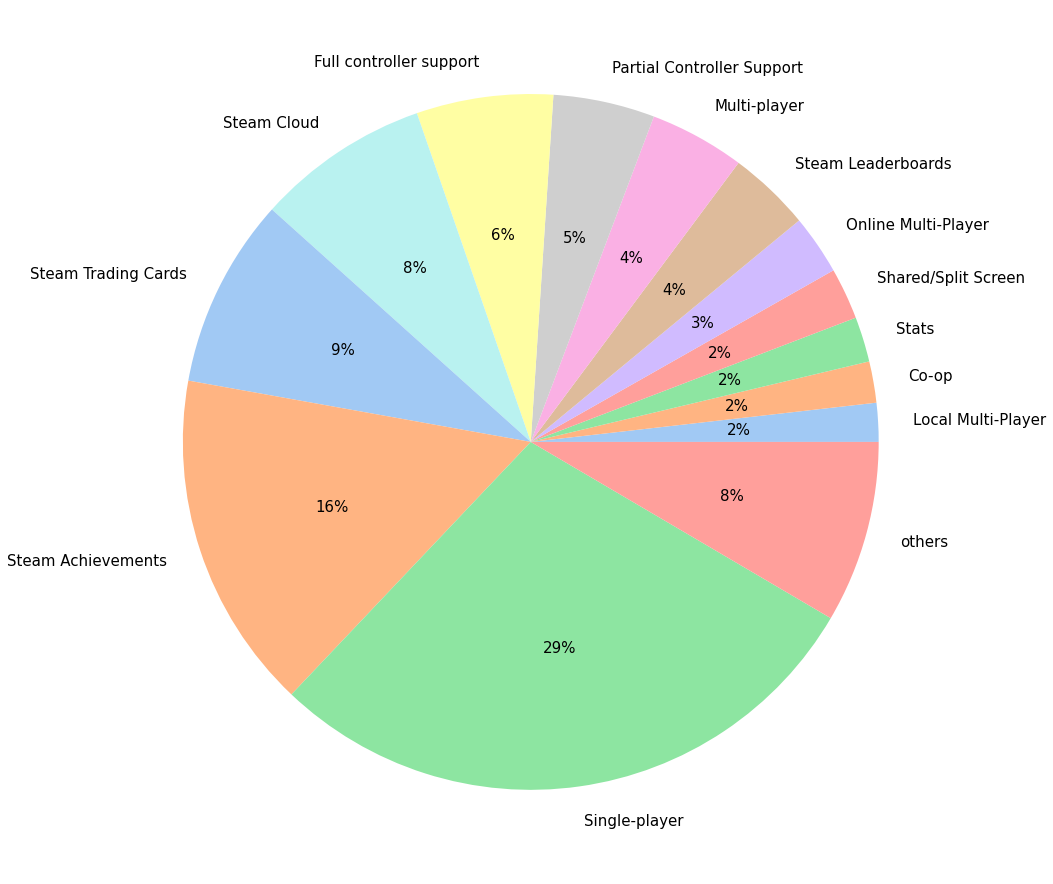

In [58]:
#plot the games distribution over differnet categories

cat_name = list(all_cat.index)[-13:]
print(cat_name)
sums = 0

for val in cat_name:
    sums+=all_cat['Num of Games'][val]

cat_name.append('others')

cat_vals = list(all_cat['Num of Games'])[-13:]
cat_vals.append(all_cat.sum()-sums)

colors = sns.color_palette('pastel')
plt.figure(figsize=(16,16))
plt.title = 'Percentage of Games belong to each category'
plt.pie(cat_vals, labels=cat_name, colors=colors, autopct='%.0f%%',textprops={'fontsize': 15})
plt.show()

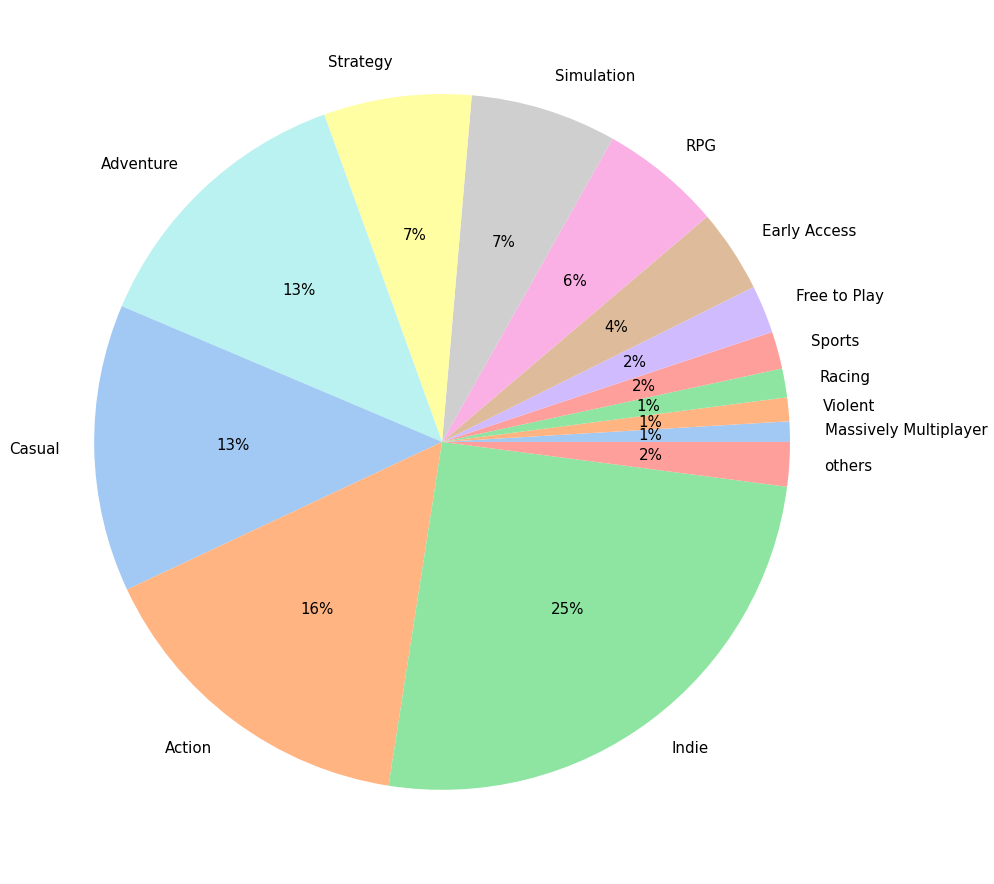

In [59]:
#plot the games distribution over differnet genres

all_gen = categories_count(games,'genres')

gen_name = list(all_gen.index)[-13:]
sums = 0

for val in gen_name:
    sums+=all_gen['Num of Games'][val]

gen_vals = list(all_gen['Num of Games'])[-13:]
gen_vals.append(all_gen.sum()-sums)

gen_name.append('others')
colors = sns.color_palette('pastel')
plt.figure(figsize=(16,16))
plt.pie(gen_vals, labels=gen_name, colors=colors, autopct='%.0f%%',textprops={'fontsize': 15})
plt.show()

In [60]:
def average_rating(game,col):
    
    '''
    games is a pd.DataFrame object with all infomation,
    extract either the genres or category column to know how averagge games, positive ratings,
    neggative ratings, prices, and owners, in each catergory
    categories/genere data semicolon, separate values by comma and count their occurence,
    
    :param x: pd.DataFrame
    :param col: str, either categorize data base on genres or categories
    :return: pd.DataFrame
    '''
    
    assert isinstance(game,pd.DataFrame)
    assert isinstance(col,str)
    assert col == 'categories' or col == 'genres'
    x = game[col]
    assert isinstance(x, pd.Series)
    
    games = game.copy()
    columns = ['positive_ratings','negative_ratings','average_playtime','price','owners']
    
    s= games[col].str.split(r";",expand = True)
    vals = s.apply(pd.value_counts).sum(axis=1,).sort_values(ascending=True).to_frame()
    vals.columns = ["Num of Games"]
    vals.index.name = col
    
    for column in columns:
        temp = games[column].astype(int)
        counts = dict.fromkeys(list(vals.index),0)
        
        for i in list(s.columns):
            
            for key in counts.keys():
                tempInfo = temp[s[i]== key]
                counts[key]+=tempInfo.sum()
            
            
        vals[column]=vals.index.map(counts)/vals['Num of Games']
    
    return vals
        

Text(0.5, 1.0, 'Original Correlation Matrix')

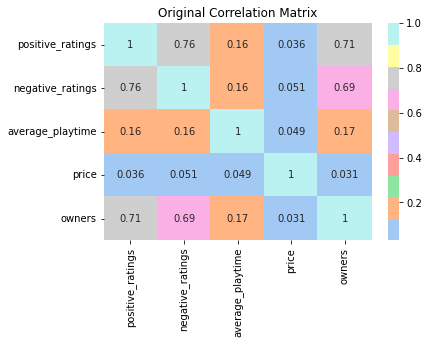

In [61]:
#correlation Matrix based on each game info
game_feature = games[['positive_ratings','negative_ratings','average_playtime','price','owners']]
game_feature.corr()

ax = plt.axes()
colors = sns.color_palette('pastel')
sns.heatmap(game_feature.corr(), annot=True,cmap = colors)
ax.set_title('Original Correlation Matrix')

Text(0.5, 1.0, 'Group Games by Genres')

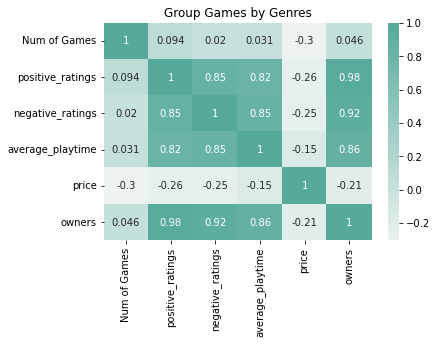

In [62]:
#Group games by genres and sum all features values and divided by number of games in each genres 
#to obtain new data, and determine the correlation matrix
info = average_rating(games,'genres')
info_corr = info.corr()
# plt.figure(figsize = (15,15))
colors = sns.color_palette('light:#5A9',as_cmap=True)

ax = plt.axes()
sns.heatmap(info_corr, annot=True,cmap = colors)
ax.set_title('Group Games by Genres')
                                         

Text(0.5, 1.0, 'Group Games by Categories')

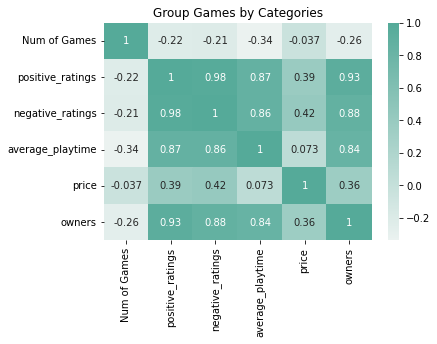

In [63]:
#Group games by categories and sum all features values and divided by number of games in each categories 
#to obtain new data, and determine the correlation matrix

info_cat = average_rating(games,'categories')

ax = plt.axes()
sns.heatmap(info_cat.corr(), annot=True,cmap = colors)
ax.set_title('Group Games by Categories')

## Data Visualization

In [1]:
from turtle import color
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import re

import itertools

default_color = sns.color_palette('pastel')

In [2]:
df = pd.read_csv("steamstore/steam.csv")
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [3]:
df = df.assign(**{'overall_reviews':df.positive_ratings + df.negative_ratings})
df = df.assign(**{'positive_rate':df.positive_ratings / df.overall_reviews})

df = df.assign(**{'has_achievments':df.achievements > 0})
df = df.assign(**{'free':df.price == 0})
df['release_date'] = pd.to_datetime(df['release_date'])

## Total Games over Years

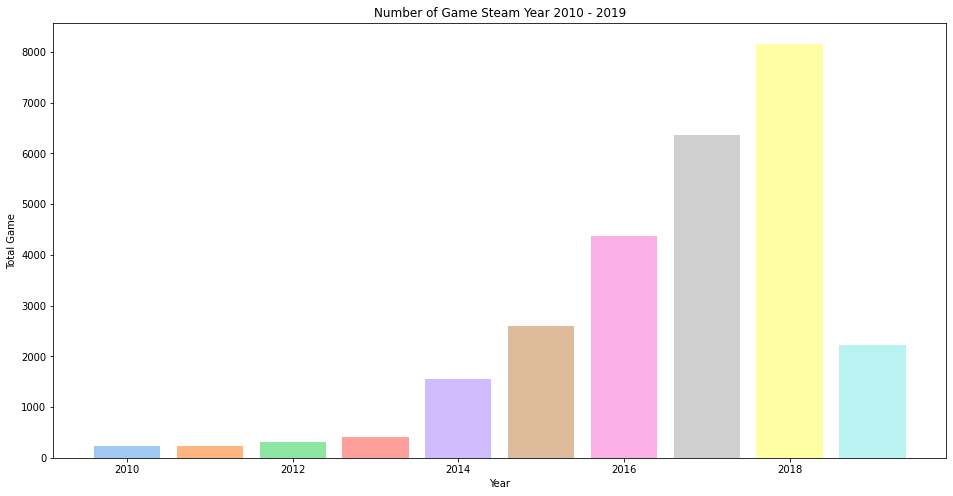

In [4]:
df['release_year'] = pd.DatetimeIndex(df['release_date']).year
steamYear = df.groupby(['release_year'])['appid'].count()

#Range Year antara 2010 - 2029
steamYearRange = steamYear.loc[2010:2019]

#Membuat plot
colors = sns.color_palette('pastel')
plt.figure(figsize=(16,8))
plt.bar(steamYearRange.index, steamYearRange,color=colors)
plt.xlabel("Year")
plt.ylabel("Total Game")
plt.title('Number of Game Steam Year 2010 - 2019')

plt.show()

## Language

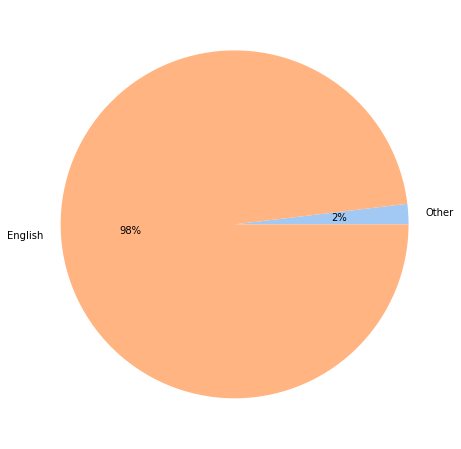

In [5]:
steamLanguage = df.groupby(['english'])['appid'].count()
#Membuat plot
language_data = list(steamLanguage)
language_lable = ['Other', 'English']
colors = sns.color_palette('pastel')
plt.figure(figsize=(16,8))
plt.pie(language_data, labels=language_lable, colors=colors, autopct='%.0f%%')
plt.show()

## Platform

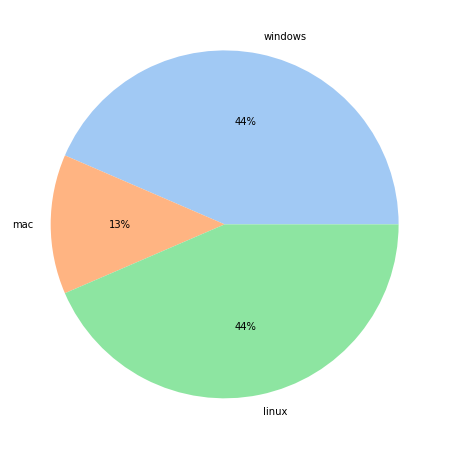

In [6]:
operating_systems = ['windows', 'mac', 'linux']

df['windows'], df['mac'], df['linux'] = df['platforms'].apply(lambda x: 'windows' in x),df['platforms'].apply(lambda x: 'mac' in x),df['platforms'].apply(lambda x: 'linux' in x)
system_data = [df[df['windows']].shape[0], df[df['mac']].shape[0], df['linux'].shape[0]]
system_labels = ['windows', 'mac', 'linux']
colors = sns.color_palette('pastel')
plt.figure(figsize=(16,8))
plt.pie(system_data, labels=system_labels, colors=colors, autopct='%.0f%%')
plt.show()

## Gernes

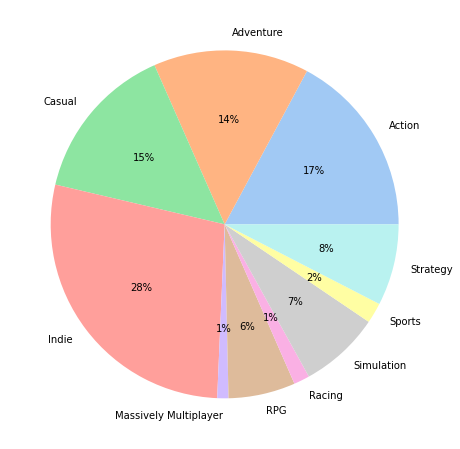

In [7]:
def process_gen_tag(df):    
  gen_cols = ['Action','Adventure','Casual','Indie',
              'Massively Multiplayer','RPG','Racing',
              'Simulation','Sports','Strategy']

  gen_col_names = []

  for col in sorted(gen_cols):
      col_name = col.lower().replace('&', 'and').replace(' ', '_')
      gen_col_names.append(col_name)
      
      df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)

  gen_sums = df[gen_col_names].sum(axis=1)
  df = df[gen_sums > 0]    
  return df
df = process_gen_tag(df)

genre_cols = ['Action','Adventure','Casual','Indie',
                'Massively Multiplayer','RPG','Racing',
                'Simulation','Sports','Strategy']
gen_cols = df.columns[-10:]
average_owners_per_genre = list(df[gen_cols].sum())

colors = sns.color_palette('pastel')
plt.figure(figsize=(16,8))
plt.pie(average_owners_per_genre, labels=genre_cols, colors=colors, autopct='%.0f%%')
plt.show()

## Price Overview and Changes

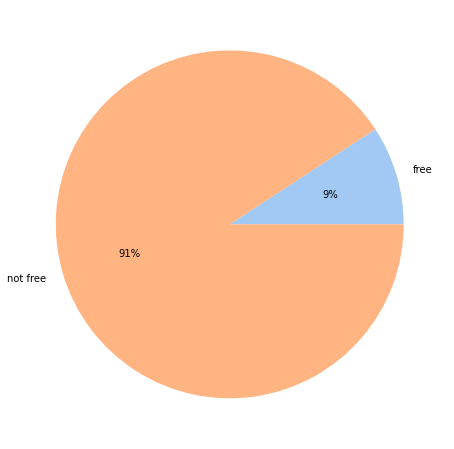

In [8]:
free, not_free = df[df['price'] == 0].shape[0], df[df['price'] != 0].shape[0]

plt.figure(figsize=(16,8))
price_data = [free, not_free]
price_lable = ['free', 'not free']
colors = sns.color_palette('pastel')
plt.pie(price_data, labels=price_lable, colors=colors, autopct='%.0f%%')
plt.show()

In [9]:
free_df, not_free_df = df[df['price'] == 0], df[df['price'] != 0]
def process_gen_tag_bar(df):
  df = process_gen_tag(df)
  genre_cols = ['Action','Adventure','Casual','Indie',
                'Massively Multiplayer','RPG','Racing',
                'Simulation','Sports','Strategy']
  gen_cols = df.columns[-10:]
  average_owners_per_genre = list(df[gen_cols].sum())
  norm = [float(i)/sum(average_owners_per_genre) for i in average_owners_per_genre]
  new_d = dict(zip(gen_cols,norm))
  large = {k: v for k, v in sorted(new_d.items(), key=lambda item: item[1],reverse=True)[:4]}
  small = {k: v for k, v in sorted(new_d.items(), key=lambda item: item[1],reverse=True)[4:]}
  ratios = list(large.values())+[sum(small.values())]
  legends = list(large.keys())+['others']
  return ratios[::-1], legends[::-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


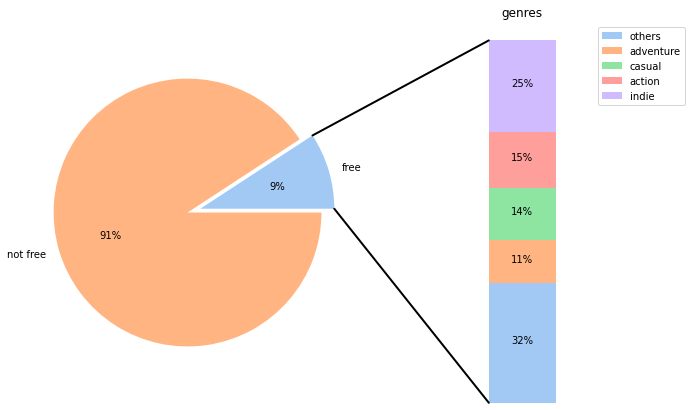

In [10]:
from matplotlib.patches import ConnectionPatch
# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
fig.subplots_adjust(wspace=0)

# pie chart parameters
explode = [0.1, 0]
price_data = [free, not_free]
price_lable = ['free', 'not free']
colors = sns.color_palette('pastel')
# rotate so that first wedge is split by the x-axis
angle = -180 * price_data[0]
ax1.pie(price_data, labels=price_lable, colors=colors, autopct='%.0f%%', explode=explode)

# bar chart parameters

xpos = 0
bottom = 0
r1,l1 = process_gen_tag_bar(free_df)
width = .2
colors = sns.color_palette('pastel')

for j in range(len(r1)):
    height = r1[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('genres')
ax2.legend(l1)
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()

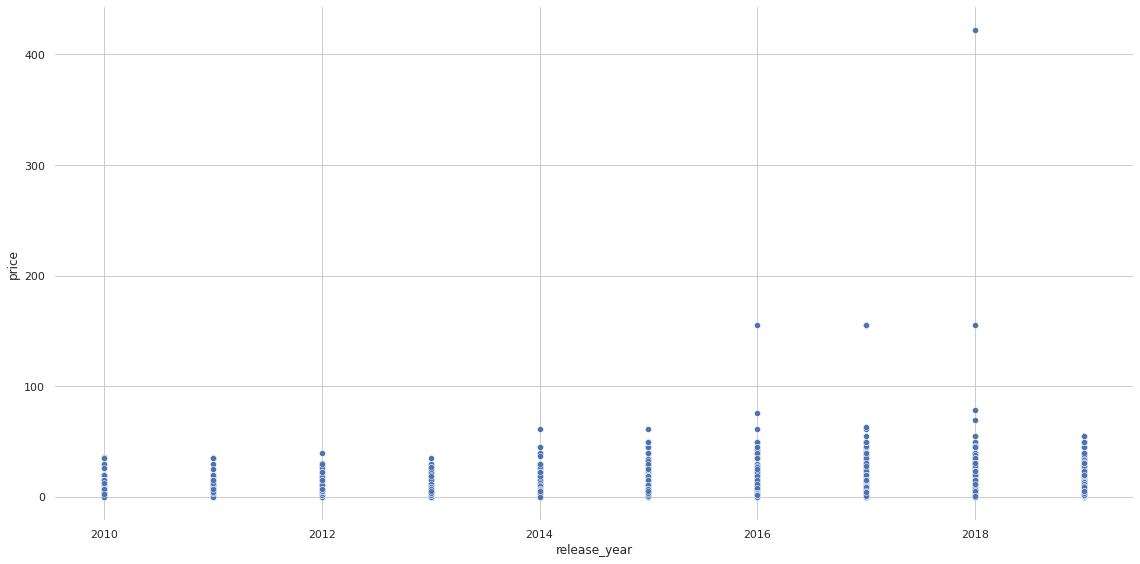

In [11]:
import matplotlib.image as image
def get_year(s):
  return int(s.split('-')[0])

df_year = df[['release_year', 'price']].copy()
df_year = df_year[df_year['release_year'].between(2010, 2019)]

sns.set_theme(style="whitegrid")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df_year,
    x="release_year", y="price",
    palette=cmap, height=8, aspect=2,
  )
g.ax.xaxis.grid(True, "minor", linewidth=1)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.show()

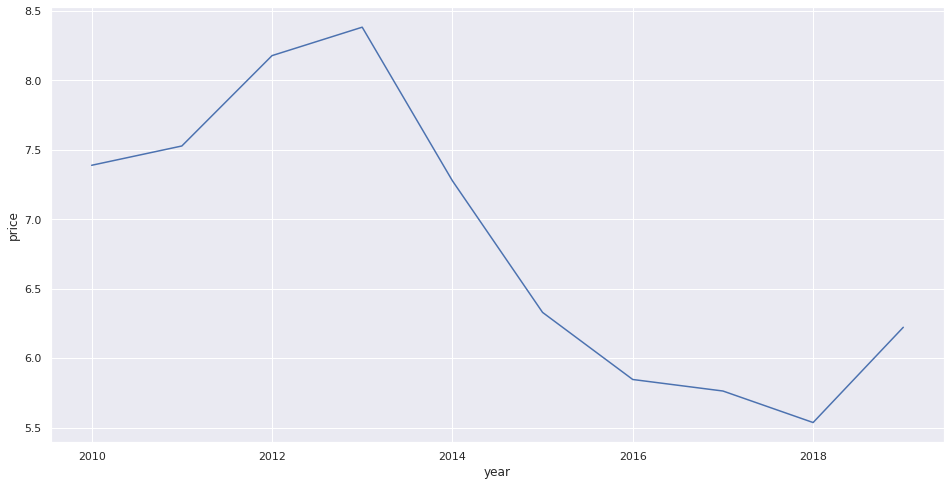

In [12]:
df_year = df[['release_date', 'price']].copy()
df_year['year'] = df_year['release_date'].apply(lambda x: x.year)
df_year = df_year[df_year['year'].between(2010, 2019)]
data_year_price = df_year.groupby(['year'])['price'].mean()
df_year_price = pd.DataFrame({'year': data_year_price.index, 'price': data_year_price.values})

plt.figure(figsize=(16,8))
sns.set_theme()
sns.lineplot(x='year', y='price', data=df_year_price)
plt.show()

In [13]:
df_year_price['num'] = list(steamYearRange)

Text(0.5, 1.0, '2016 to 2019 Announcements')

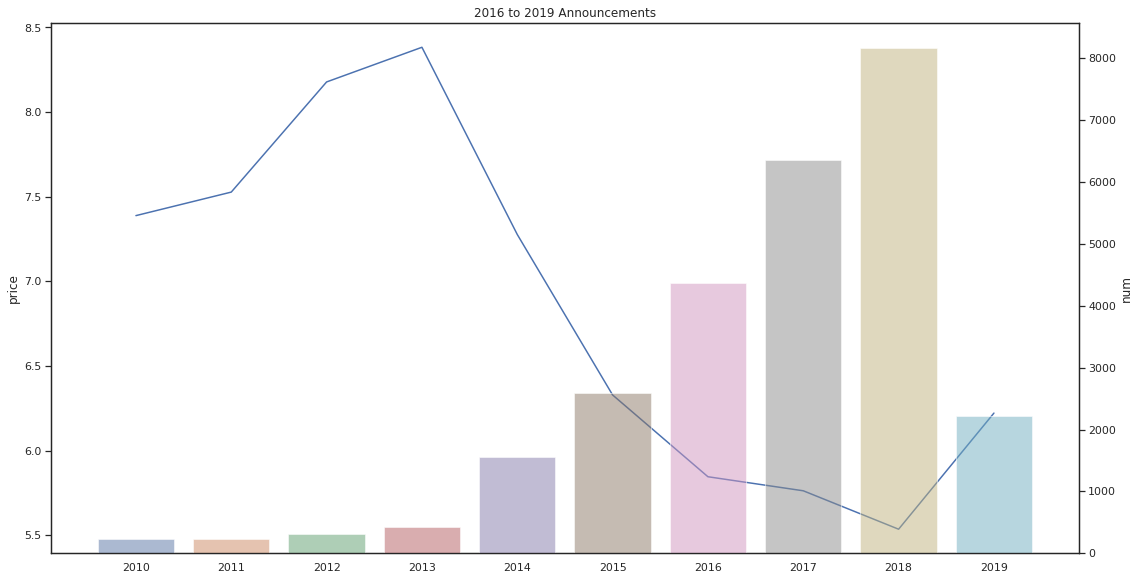

In [14]:
sns.set_theme(style="white")
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
sns.barplot(x="year", y="num", data=df_year_price, ax=ax2, alpha=.5)
sns.lineplot(x=np.arange(0,len(df_year_price)), y="price", data=df_year_price, ax=ax1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('2016 to 2019 Announcements')

## Publishers

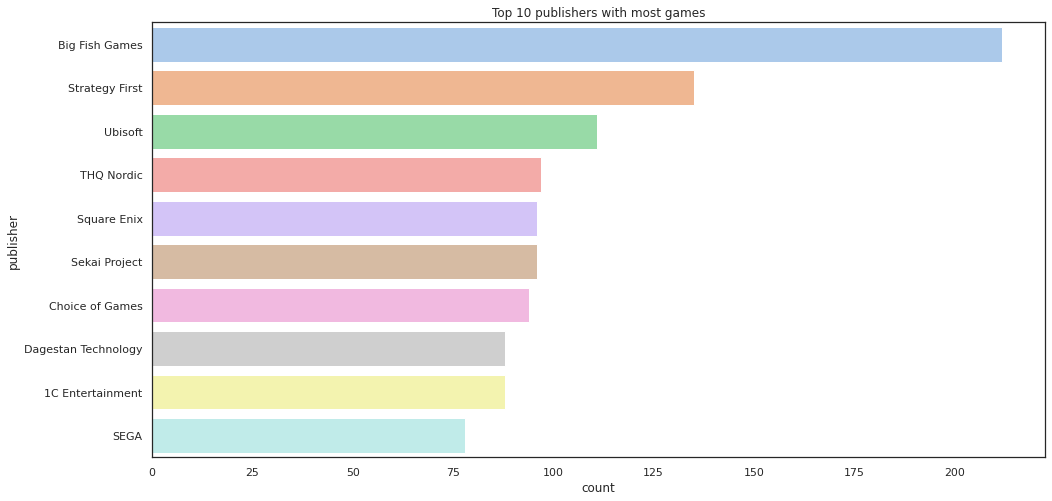

In [15]:
top=10
plt.figure(figsize=(16,8))
plt.title(f'Top {top} publishers with most games')

colors = sns.color_palette('pastel')
sns.countplot(y="publisher", data=df,
        order=df.publisher.value_counts().iloc[:top].index,
        palette='pastel')

plt.show()

## Developers

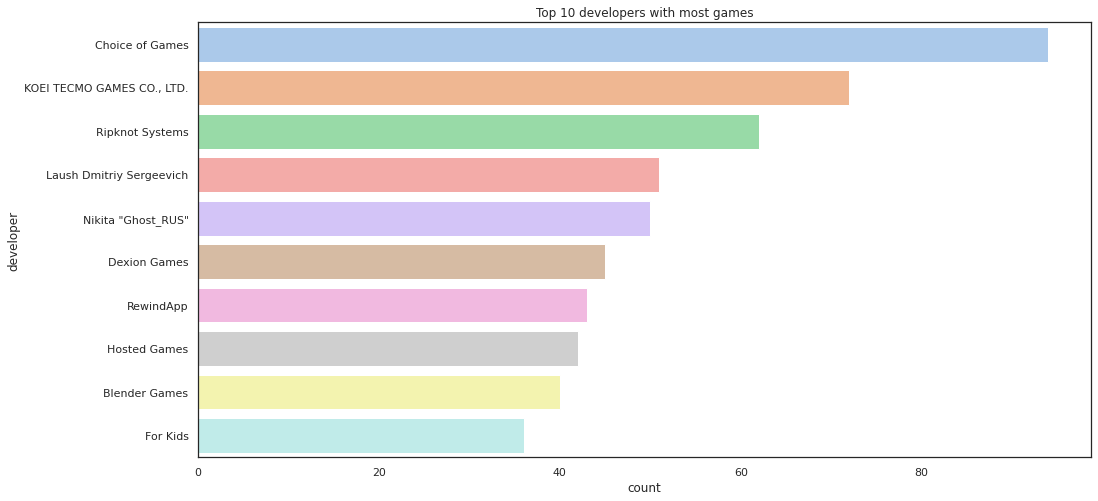

In [16]:
top=10
plt.figure(figsize=(16,8))
plt.title(f'Top {top} developers with most games')
sns.countplot(y='developer', data=df, order=df.developer.value_counts().iloc[:10].index, palette='pastel')
plt.show()

In [17]:
agg_developers = df.groupby('developer').agg({'overall_reviews': ['min', 'max', 'median'], 'name':'count', 'positive_rate': 'mean', 'price':'mean'})

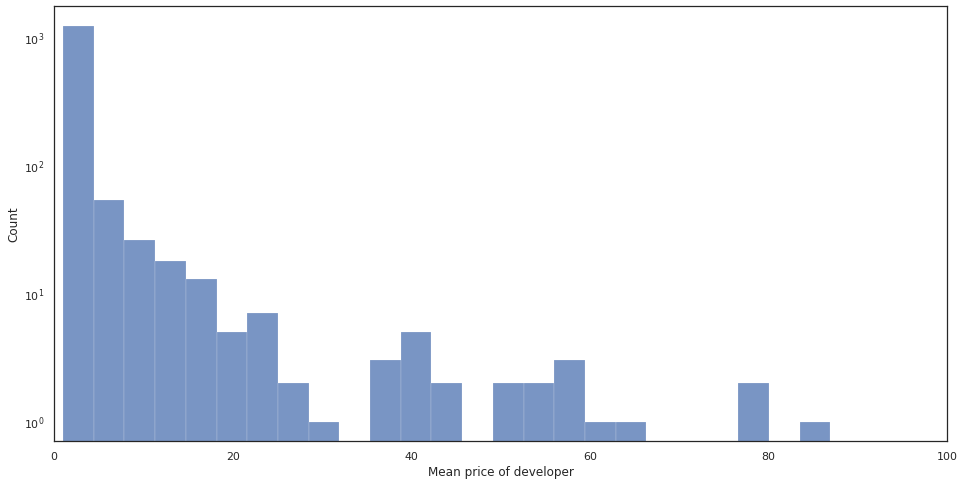

In [18]:
plt.figure(figsize=(16,8))

g = sns.histplot(agg_developers[('price', 'mean')].value_counts(), kde=False,bins=500)
g.set_yscale('log')
plt.xlim((0,100))
plt.xlabel('Mean price of developer')
plt.show()

## Average Playtime

Text(0.5, 0, 'Average playtime')

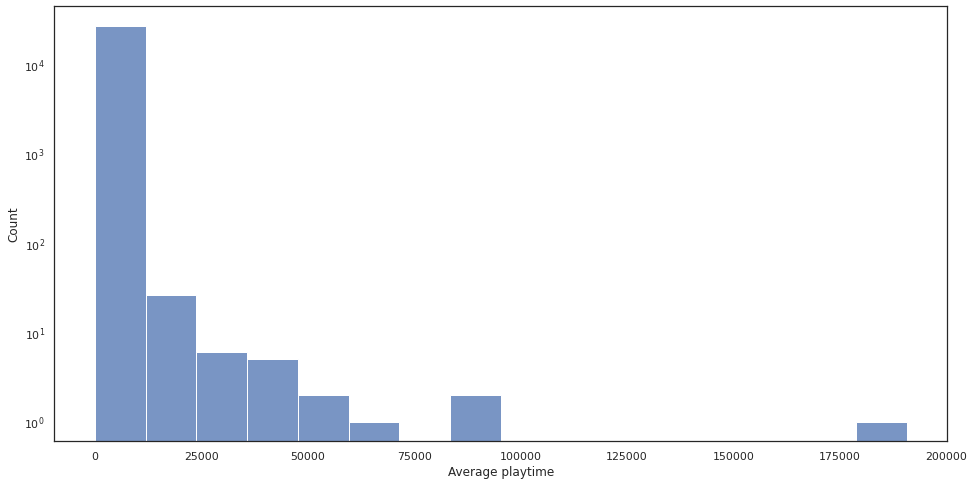

In [19]:
plt.figure(figsize=(16,8))

g = sns.histplot(df.average_playtime, kde=False)
g.set_yscale('log')

plt.ylabel("Count")
plt.xlabel("Average playtime")

## Rating

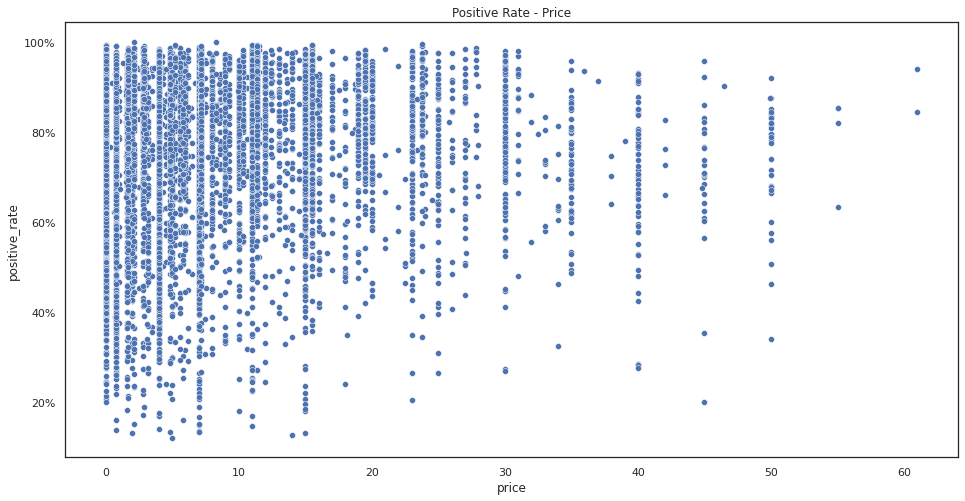

In [20]:
plt.figure(figsize=(16,8))
plt.title('Positive Rate - Price')
g = sns.scatterplot(x="price", y="positive_rate", data=df[(df.price <= 100) & (df.overall_reviews > 100)])

vals = g.get_yticks()
_ = g.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

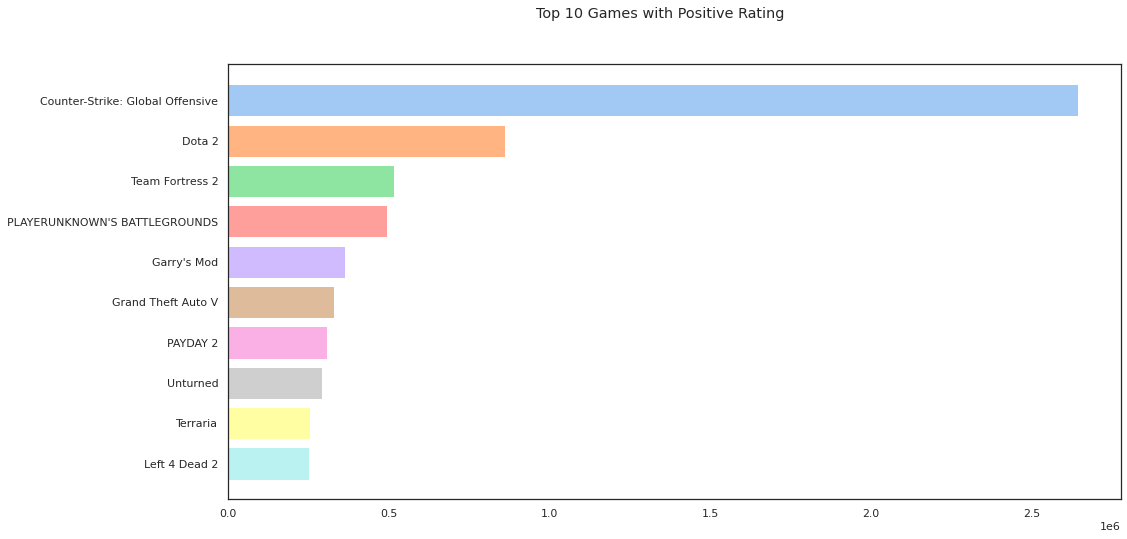

In [21]:
positiveMessage = df.sort_values(by='positive_ratings', ascending=False).iloc[:10]
positiveRating = positiveMessage['positive_ratings']
positiveName = positiveMessage['name']

plotFigure, plotRating = plt.subplots(figsize=(16, 8))
colors = sns.color_palette('pastel')
plotRating.barh(positiveName, positiveRating, color=colors)
plotRating.invert_yaxis()
plotFigure.suptitle('Top 10 Games with Positive Rating')

plt.show()

## Various categories

In [22]:
categories_set = set()
for i in df.categories.str.split(';'):
    categories_set.update(i)
categories_set

d = dict()
category_set = df.categories.str.split(';').apply(set)
for category in categories_set:
    d[category] = category_set.apply(lambda row: category in row)
df = df.assign(**d)

In [23]:
trunc_year = 2010
truncated_df = df[df.release_date.dt.year>trunc_year]
palette = sns.color_palette('pastel')
def over_the_years(df, column_name, palette=palette, rate_lim=None):

    fig = plt.figure(figsize=(24, 12))
    
    yearly = df.groupby(df.release_date.dt.year.rename('release_year'))\
        .agg('count').appid.rename('count')
    p = df.groupby(df.release_date.dt.year)[column_name].mean()
    
    plt.subplot(121)
    g = sns.barplot(x=yearly.index, y=yearly, color=palette[1],label="Overall")
    g2 = sns.barplot(x=yearly.index, y=yearly * p, color=palette[2], label=f"{column_name} games")
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(f'{column_name} over the years')
    plt.xlabel('Release year')
    
    plt.subplot(122)
    g3 = sns.barplot(x=p.index, y=p, color=palette[2])
    plt.xticks(rotation=45)
    plt.xlabel('Release year')
    plt.ylabel(f'{column_name} rate')
    if rate_lim:
        g3.set_ylim(rate_lim)
    vals = g3.get_yticks()
    g3.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

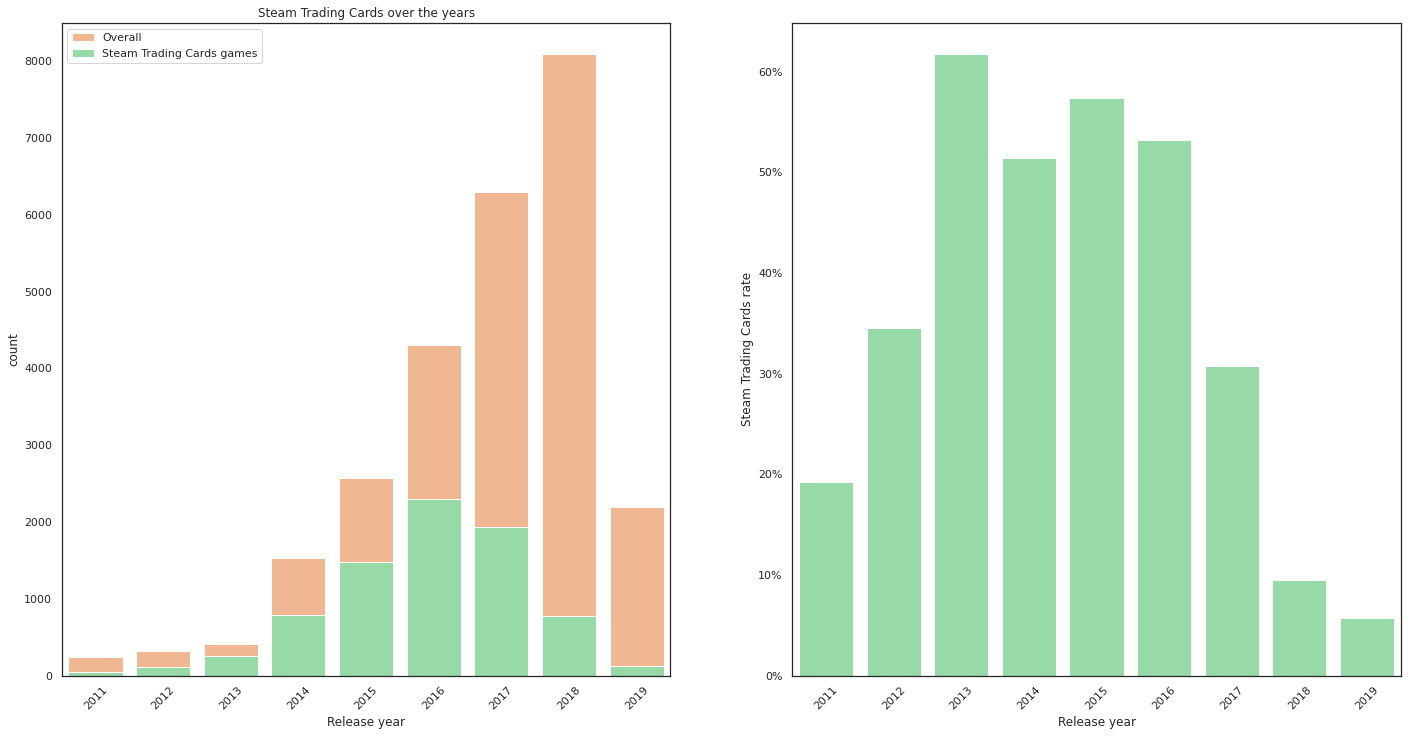

In [24]:
over_the_years(truncated_df, 'Steam Trading Cards')

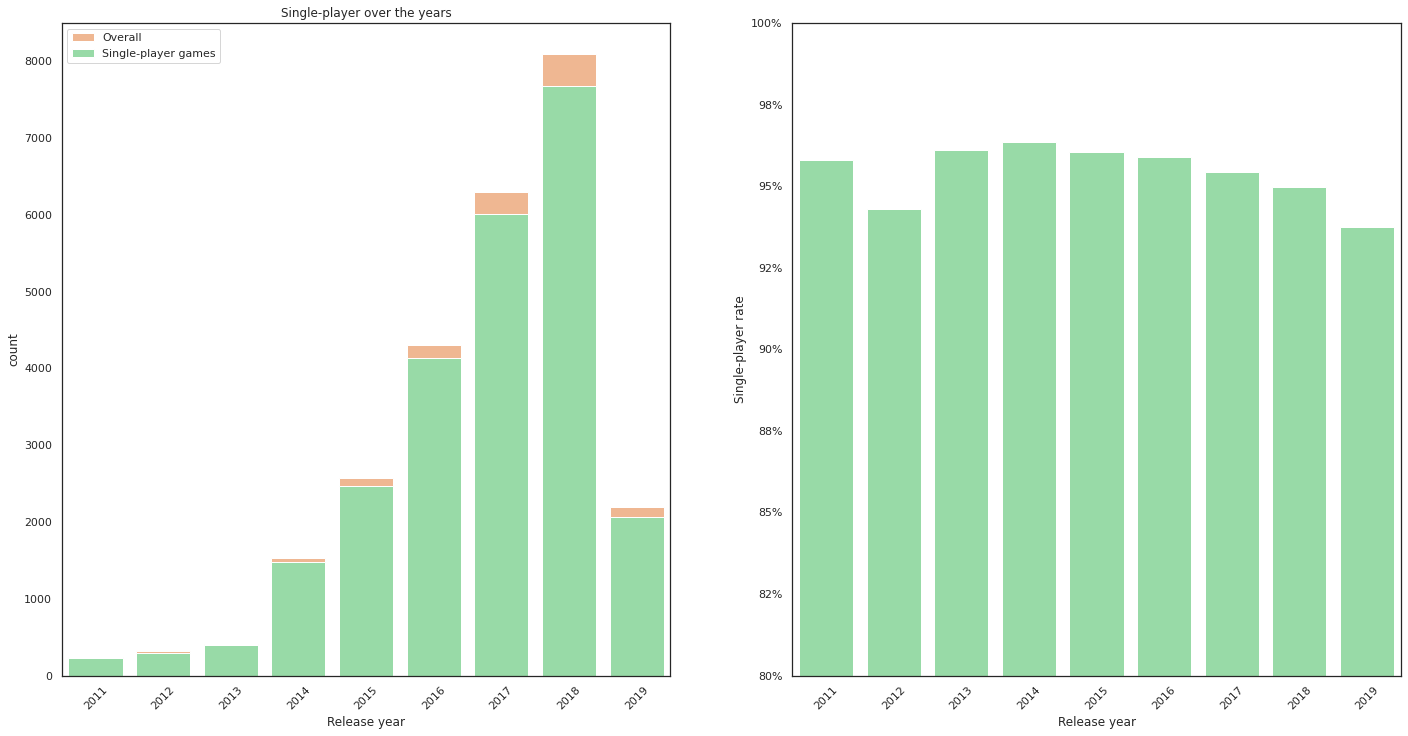

In [25]:
over_the_years(truncated_df, 'Single-player', rate_lim=(0.8,1.0))

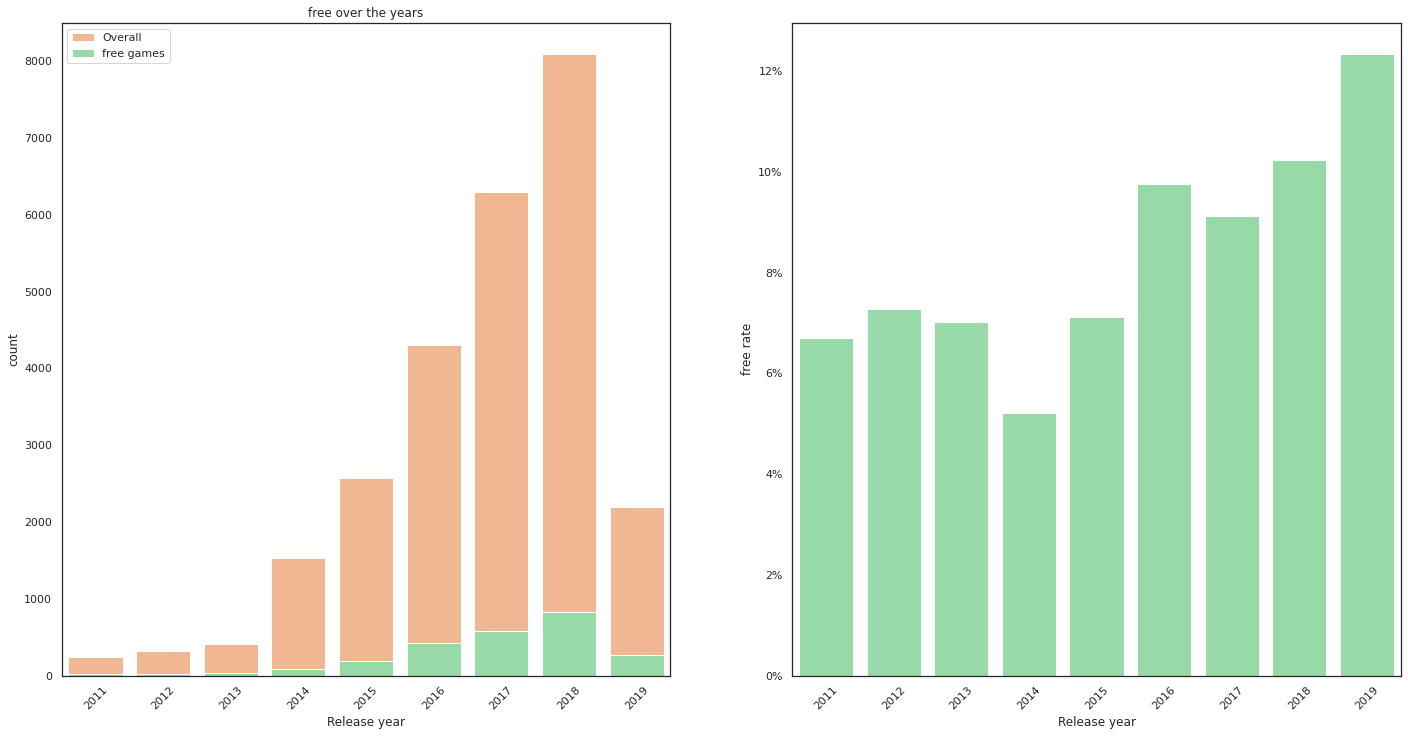

In [26]:
over_the_years(truncated_df, 'free')

## Clustering

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import cv2

In [ ]:
G = nx.Graph()
visitedN = set()
visitedE = set()
genres = set()

In [ ]:
##tag clustering
for t in df['steamspy_tags']:
  tags = t.split(';')
  for i in range(len(tags)):
    if not tags[i] in visitedN:
      G.add_node(tags[i],weight=1)
      visitedN.add(tags[i])
    else:
      G.nodes[tags[i]]['weight']+=1

  for i in range(len(tags)):
    for j in range(i+1, len(tags)):
      if (tags[i], tags[j]) in visitedE or (tags[j], tags[i]) in visitedE:
        G[tags[i]][tags[j]]['weight']+=1
      else:
        G.add_edge(tags[i],tags[j],weight=1)
        visitedE.add((tags[i], tags[j]))
        visitedE.add((tags[j], tags[i]))

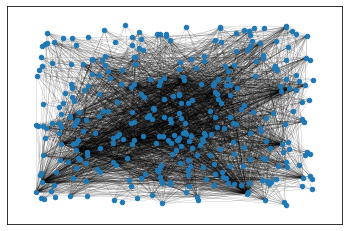

In [ ]:
pos = nx.random_layout(G)
nx.drawing.nx_pylab.draw_networkx_nodes(G, pos, None, 20)
nx.drawing.nx_pylab.draw_networkx_edges(G, pos, None, 0.1)

In [ ]:
clustering = nx.clustering(G)
nx.set_node_attributes(G, clustering, "clustering")
nx.write_gml(G, "tags.gml")

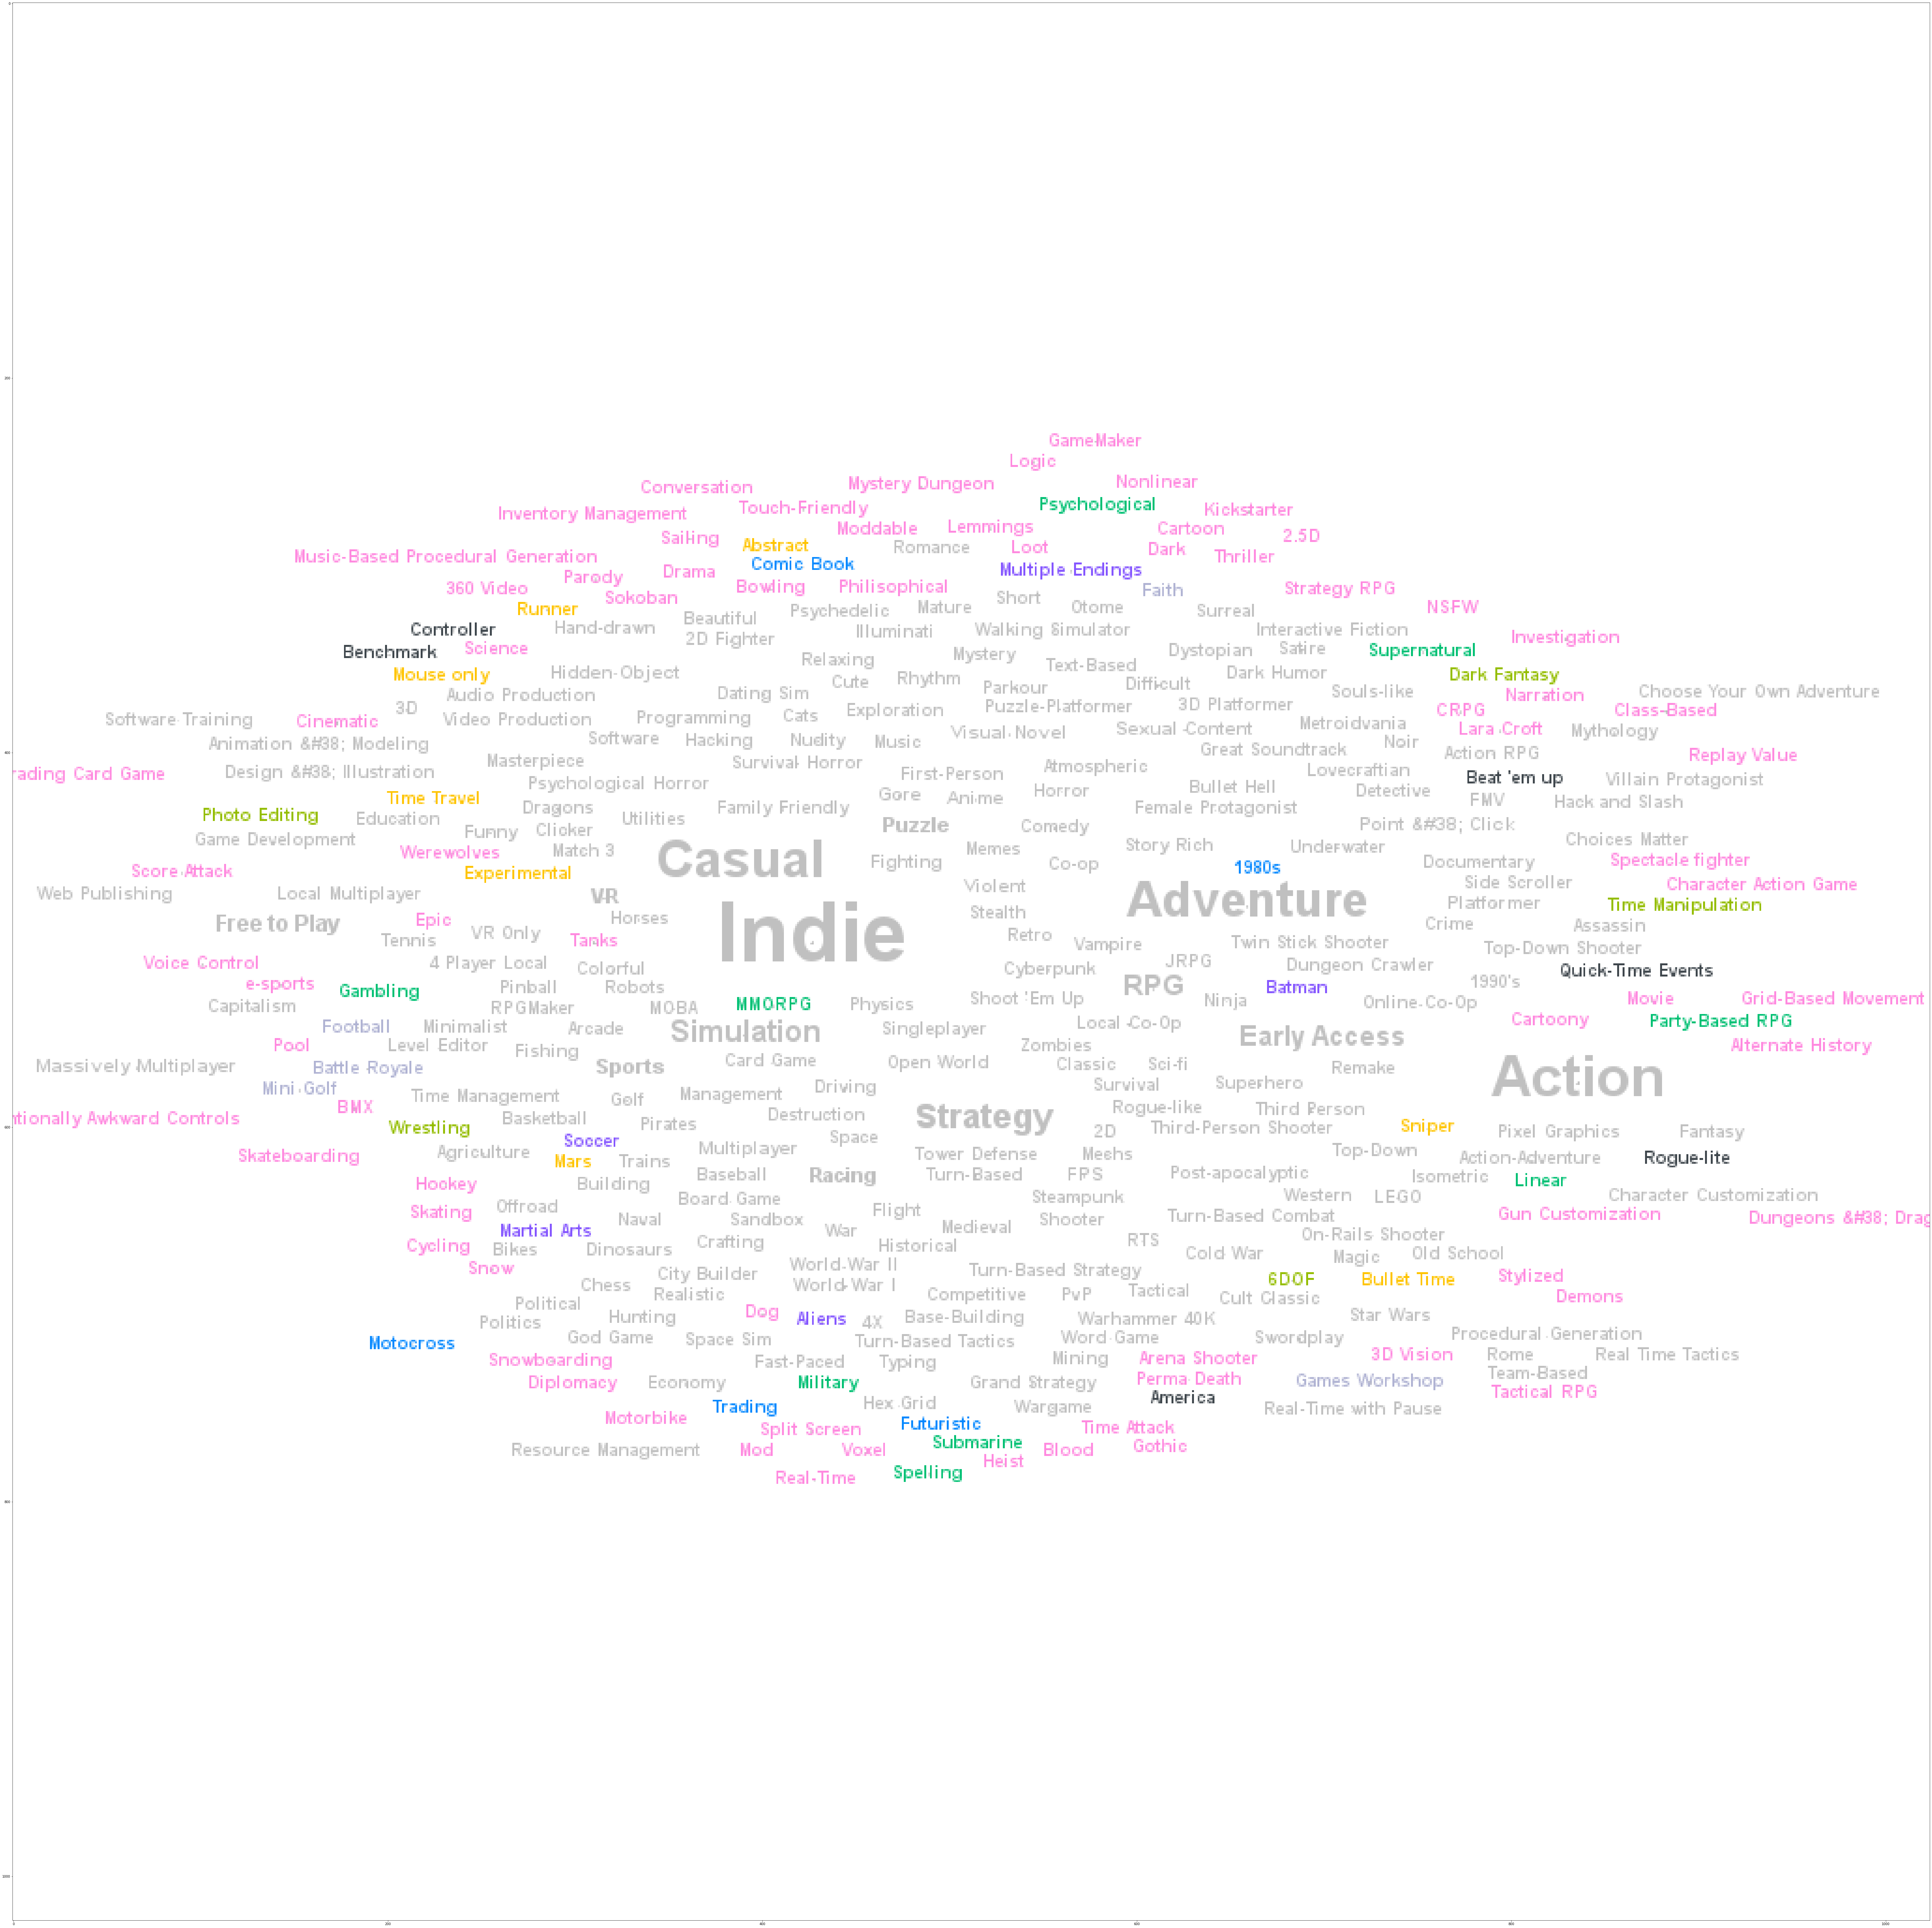

In [ ]:
Gtag = cv2.imread("tags.png")
plt.figure(figsize=(110, 110))
plt.imshow(Gtag)

## Recommendation System

In [ ]:
import gzip
from collections import defaultdict

In [ ]:
def parse_gzip_helper(f):
    for l in gzip.open(f):
        yield eval(l)

def parse_gzip(filename):
    return list(parse_gzip_helper(filename))

In [ ]:
path = './steamrecommand/steam_games.json.gz'
games = parse_gzip(path)
game_list = []
for game in games:
    temp = []
    if 'id' in game:
        temp.append(game['id'])
    else:
        temp.append(0)
    if 'app_name' in game: 
        temp.append(game['app_name'])
    else:
        temp.append('')
    if 'tags' in game:
        temp.append(game['tags'])
    else:
        temp.append([])
    game_list.append(temp)

In [ ]:
path = './steamrecommand/australian_users_items.json.gz'
temp1 = parse_gzip(path)

In [ ]:
user_list = []
for user in temp1:
    temp = []
    temp.append(user['steam_id'])
    bought_list = []
    for g in user['items']:
        bought_list.append(g['item_id'])
    temp.append(bought_list)
    user_list.append(temp)

In [ ]:
path = './steamrecommand/bundle_data.json.gz'
bundles = parse_gzip(path)
bundle_list = []
for b in bundles:
    temp = []
    for i in b['items']:
        temp.append(i['item_id'])
    bundle_list.append(temp)

In [ ]:
numbers = [k[0] for k in game_list]
total = 0
missing_game = 0
for i in bundle_list:
    for k in i:
        total+=1
        if k not in numbers:
            game_list.append([k,'',[]])
            missing_game+=1
print(missing_game/total)

0.1452482269503546


__we currently have__: 

    game_list: game_id and the genres  
    user_list: user_id and what games he/she/it purchased  
    bundles: steam wants to sell them together, which should be given high consideration for similarities, and not much missing game in our list(only 14% game not found and then added  
   
__the plan is__:  
  
    assgin different scores to each:
    genres similarities: based on user may perfer certain types of game: horror or action and so on
    user similirities: based on the typical recommendation way that: PEOPLE BOUGHT THIS ALSO BOUGHT
    bundles: games may be bundled for series or other issue, at least they are recommended by the seller, they may be well related
    percentages are assigned depending on the final results
    

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
userOfGames = defaultdict(set)
gameOfUser = defaultdict(set)
genreOfGames = defaultdict(set)
for u in user_list:
    user_id = u[0]
    for g in u[1]:
        userOfGames[g].add(user_id)
        gameOfUser[user_id].add(g)
for g in game_list:
    game_id = g[0]
    for t in g[2]:
        genreOfGames[game_id].add(t)

In [ ]:
def type_sim(game_id):
    sim = []
    for g in game_list:
        if g[0] == game_id:
            sim.append(0)
        else:
            sim.append(Jaccard(genreOfGames[game_id],genreOfGames[g[0]]))
    return sim

def user_sim(game_id):
    sim = []
    for g in game_list:
        if g[0] == game_id:
            sim.append(0)
        else:
            sim.append(Jaccard(userOfGames[game_id],userOfGames[g[0]]))
    return sim

def bundle_bonus(game_id):
    bonus = defaultdict(int)
    for b in bundle_list:
        if game_id not in b:
            continue
        else:
            for g in b:
                if g == game_id:
                    continue
                else:
                    bonus[g]+=0.1
    return bonus

In [ ]:
def game_recommender(game_id,top = 10,type_w = 0.4,user_w = 0.4,bund_w = 0.2):
    type_l = type_sim(game_id)
    user_l = user_sim(game_id)
    bonus = bundle_bonus(game_id)
    score_list = []
    for i in range(len(game_list)):
        if game_id == game_list[i][0]:
            print(game_list[i][1])
            continue
        temp = []
        temp.append(type_w*type_l[i]+user_w*user_l[i]+bund_w*bonus[game_list[i][0]])
        temp.append(game_list[i][1])
        score_list.append(temp)
    score_list = sorted(score_list,reverse=True)
    game_name = []
    for i in range(top):
        print(score_list[i][1],score_list[i][0])
        #game_name.append(score_list[i][1])
    #return game_name

In [ ]:
game_recommender('768880')

Beach Rules
Naughty Elves 0.26666666666666666
Louie Cooks 0.24
Toast Time 0.22857142857142856
NGHTMN 0.22857142857142856
Carrie's Order Up! 0.22857142857142856
Winter Novel 0.2
Universe in Fire 0.2
True or False 2 0.2
Tower of Archeos 0.2
The Normal Day 0.2
